# Simple solph heat pump model

- linear standard transformer
- one Carnot COP per temperature level and constant efficieny
- use efficiency from sheet, typically 3 °C
- no minimum load

...

The COP of the heat pump can be calculated from the ratio of total produced heat $\dot Q_\text{prod}$ to the total
required work \sum \dot W in eq. {eq}`cop-heat-pump-general`. For a simple 4-component heat pump setup, the definitions
simplifies to a single heat output at the condenser and a single work input at the compressor eq.
{eq}`cop-heat-pump-simple`. We use the absolute value of the heat produced to obtain a positive COP value when following
a system oriented sign convention.

```{math}
    :label: cop-heat-pump-general
    \text{COP} = \frac{|\sum \dot Q_\text{prod}|}{\sum \dot W}
```

```{math}
    :label: cop-heat-pump-simple
    \text{COP} = \frac{|\dot Q_\text{prod}|}{\dot W}
```

Since we want to impose the COP on our energy system model, we need to find a adequate value for the use case 
implemented. One way of doing this, would be by calculating the Carnot COP {math}`\text{COP}_\text{c}`, which is the
thermodynamically best COP possible and adjusting its value with an efficiency factor {math}`\eta_\text{hp}`. For a
simplyfied approach, the Carnot COP can be obtained with eq. {eq}`carnot-cop-heat-pump`.

```{tip}
In most cases the approximation of the Carnot COP with this equation is sufficient, the actual Carnot efficiency however
has to be calculated on a dedicated thermodynamic model. There is a dedicated section {ref}`tespy-carnot-cop`, which 
explains the theory of the Carnot COP with an example of how to calculate that with TESPy.
```

```{math}
    :label: carnot-cop-heat-pump
    \text{COP}_\text{c} = \frac{T_\text{max}}{T_\text{max} - T_\text{min}}
```

The efficiency factor is usually considered a constant value. With that, we can calculate the COP based on an ambient
temperature profile and the target heating temperature:

```{math}
    :label: cop-heat-pump-carnot-and-efficiency
    \text{COP} = \frac{T_\text{max}}{T_\text{max} - T_\text{min}} \cdot \eta_\text{hp}
```


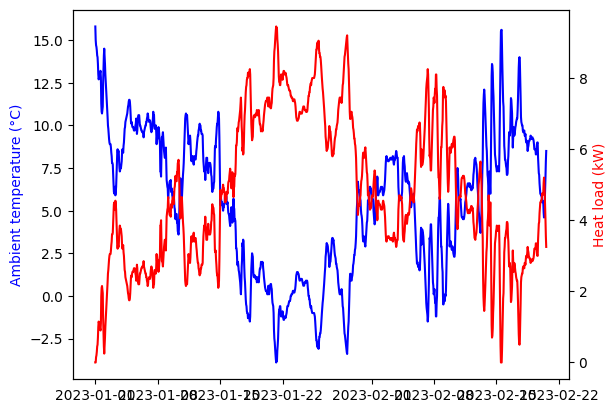

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_temperature_data():
    """Returns temperature (in °C) over timestamp
    """
    # weather data from https://wetterstation.physik.rwth-aachen.de/datenbank.php
    df = pd.read_csv("../2023_Stundenstatistik.txt", delim_whitespace=True)
    df.index = (pd.to_datetime(
        [
            f"{str(year)}-{str(month)}-{str(day)} {str(hour)}:00:00"
            for year, month, day, hour in zip(df['#Jahr'], df['Monat'], df['Tag'], df['Stunde'])
        ]
    ))
    df = df[["T_Mid"]]
    df.rename(columns={"T_Mid": "Ambient temperature (°C)"}, inplace=True)

    return df


input_data = load_temperature_data()

# A crude demand model should be enough for us. Let the demand be 500 W per K below 15 °C.
input_data["Heat load (kW)"] = (0.5 * (15 - input_data["Ambient temperature (°C)"])).clip(lower=0)

plt.plot(input_data["Ambient temperature (°C)"], "b-")
plt.ylabel("Ambient temperature (°C)").set_color("blue")

plt.twinx()

plt.plot(input_data["Heat load (kW)"], "r-")
plt.ylabel("Heat load (kW)").set_color("red")

plt.show()


Now, we want to add an air-source heat-pump centered heat supply system.  Short online research for example yields:

* Rated heating output (kW) at operating point A7/W35: 9.1 kW
* Coefficient of performance ε (COP) A7/W35: 4.9

(https://www.viessmann.co.uk/en/products/heat-pump/vitocal-150a.html,  type 150.A16)

In [88]:
datasheet_cop = 4.9
carnot_cop_7_35 = (35+273.15) / (35-7)
cpf = datasheet_cop / carnot_cop_7_35
hp_thermal_power = 9.1  # kW

input_data["constant efficiency COP"] = cpf * (35+273.15) / (35 - input_data["Ambient temperature (°C)"])


In [89]:
import oemof.solph as solph

cop = input_data["constant efficiency COP"][:-1]
demand = input_data["Heat load (kW)"][:-1]

es = solph.EnergySystem(timeindex=input_data.index, infer_last_interval=False)

b_electricity = solph.Bus(label="electricity")
b_heat_35C = solph.Bus(label="heat 35C")
es.add(b_electricity, b_heat_35C)

electricity_grid = solph.components.Source(
    label="electricity grid",
    outputs={b_electricity: solph.Flow(variable_costs=0.4)},  # €/kWh
)

heat_demand = solph.components.Sink(
    label="heat demand",
    inputs={b_heat_35C: solph.Flow(nominal_value=1, fix=demand)},  # kW
)
es.add(electricity_grid, heat_demand)


heat_pump = solph.components.Transformer(
    label="heat pump",
    inputs={b_electricity: solph.Flow()},
    outputs={b_heat_35C: solph.Flow(nominal_value=hp_thermal_power)},
    conversion_factors={
        b_electricity: 1 / cop,
        b_heat_35C: 1,
    },
)

es.add(heat_pump)

es.add(solph.components.Transformer(
    label="heating rod",
    inputs={b_electricity: solph.Flow()},
    outputs={b_heat_35C: solph.Flow()},
))

thermal_storage = solph.components.GenericStorage(
    label='thermal_storage',
    inputs={b_heat_35C: solph.Flow()},
    outputs={b_heat_35C: solph.Flow()},
    nominal_storage_capacity=8.7,  # Assume 5 k of spread and 1.5 m³ volume 
)

es.add(thermal_storage)

model = solph.Model(energysystem=es)

model.solve()

results = solph.processing.results(model)



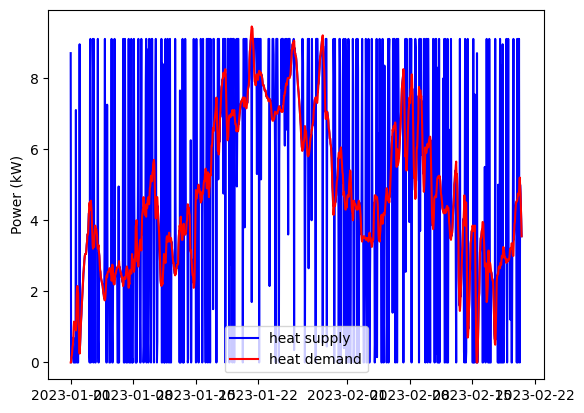

Electricity demand: 1321.0 kWh


In [92]:

plt.plot(results[(heat_pump, b_heat_35C)]["sequences"], "b-", label="heat supply")
plt.plot(demand, "r-", label="heat demand")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()

electricity_consumption = float(results[(electricity_grid, b_electricity)]["sequences"].sum())
print(f"Electricity demand: {electricity_consumption:.1f} kWh")
